In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
%pip install scikit-learn
!pip install datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import warnings
warnings.filterwarnings('ignore')

In [3]:
air_store_info = pd.read_csv('air_store_info.csv')
air_visit_data = pd.read_csv('air_visit_data.csv')
date_info = pd.read_csv('date_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
# Преобразование дат
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])

# Добавление дня недели
air_visit_data['dayofweek'] = air_visit_data['visit_date'].dt.dayofweek
date_info['dayofweek'] = date_info['calendar_date'].dt.dayofweek

In [5]:
def merge_data(air_visit_data, date_info, air_store_info):
    df = pd.merge(air_visit_data, date_info,
                 left_on=['visit_date', 'dayofweek'],
                 right_on=['calendar_date', 'dayofweek'],
                 how='left')

    df = pd.merge(df, air_store_info, on='air_store_id', how='left')

    # Добавляем признаки времени
    df['month'] = df['visit_date'].dt.month
    df['year'] = df['visit_date'].dt.year
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    return df

final_df = merge_data(air_visit_data, date_info, air_store_info)

In [6]:
# 4. Подготовка данных для обучения

# Создание дополнительных признаков
final_df['avg_visitors_per_dow'] = final_df.groupby('day_of_week')['visitors'].transform('mean')
final_df['avg_visitors_per_store'] = final_df.groupby('air_store_id')['visitors'].transform('mean')
final_df['avg_visitors_per_genre'] = final_df.groupby('air_genre_name')['visitors'].transform('mean')
final_df['avg_visitors_per_area'] = final_df.groupby('air_area_name')['visitors'].transform('mean')

# Кодирование категориальных переменных
le = LabelEncoder()
final_df['air_genre_name_encoded'] = le.fit_transform(final_df['air_genre_name'])
final_df['air_area_name_encoded'] = le.fit_transform(final_df['air_area_name'])
final_df['day_of_week_encoded'] = le.fit_transform(final_df['day_of_week'])

# Расширенный набор признаков
features = [
    'air_genre_name_encoded', 'air_area_name_encoded', 'day_of_week_encoded',
    'holiday_flg', 'avg_visitors_per_dow', 'avg_visitors_per_store',
    'avg_visitors_per_genre', 'avg_visitors_per_area'
]

# Разделение данных с учетом размера ресторана
size_threshold = final_df['visitors'].median()
small_restaurants = final_df[final_df['visitors'] <= size_threshold]
large_restaurants = final_df[final_df['visitors'] > size_threshold]

# Создание отдельных наборов данных
X_small = small_restaurants[features]
y_small = small_restaurants['visitors']
X_large = large_restaurants[features]
y_large = large_restaurants['visitors']

# Разделение на тренировочную и тестовую выборки
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=42)
X_train_large, X_test_large, y_train_large, y_test_large = train_test_split(X_large, y_large, test_size=0.3, random_state=42)

# Объединение тестовых данных для оценки
X_test = pd.concat([X_test_small, X_test_large])
y_test = pd.concat([y_test_small, y_test_large])

In [7]:
final_df

,air_store_id,visit_date,visitors,dayofweek,calendar_date,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude,...,month,year,is_weekend,avg_visitors_per_dow,avg_visitors_per_store,avg_visitors_per_genre,avg_visitors_per_area,air_genre_name_encoded,air_area_name_encoded,day_of_week_encoded
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016-01-13,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,...,1,2016,0,19.230121,22.782609,18.723532,19.609418,4,62,6
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016-01-14,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,...,1,2016,0,18.922702,22.782609,18.723532,19.609418,4,62,4
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016-01-15,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,...,1,2016,0,23.072737,22.782609,18.723532,19.609418,4,62,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016-01-16,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,...,1,2016,1,26.313688,22.782609,18.723532,19.609418,4,62,2
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016-01-18,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,...,1,2016,0,17.177009,22.782609,18.723532,19.609418,4,62,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,1,2017-04-18,Tuesday,0,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,...,4,2017,0,17.672137,5.568376,19.861872,8.521649,11,72,5
252104,air_24e8414b9b07decb,2017-04-19,6,2,2017-04-19,Wednesday,0,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,...,4,2017,0,19.230121,5.568376,19.861872,8.521649,11,72,6
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017-04-20,Thursday,0,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,...,4,2017,0,18.922702,5.568376,19.861872,8.521649,11,72,4
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017-04-21,Friday,0,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,...,4,2017,0,23.072737,5.568376,19.861872,8.521649,11,72,0


In [29]:
# 5. Обучение моделей
from sklearn.ensemble import GradientBoostingRegressor

# Модель для малых ресторанов
model_small = GradientBoostingRegressor(
    n_estimators=250,
    learning_rate=0.5,
    max_depth=7,
    min_samples_split=6,
    random_state=22
)
model_small.fit(X_train_small, y_train_small)

# Модель для крупных ресторанов
model_large = GradientBoostingRegressor(
    n_estimators=350,
    learning_rate=0.05,
    max_depth=9,
    min_samples_split=8,
    random_state=32
)
model_large.fit(X_train_large, y_train_large)

# Предсказания
y_pred_small = model_small.predict(X_test_small)
y_pred_large = model_large.predict(X_test_large)
y_pred = np.concatenate([y_pred_small, y_pred_large])

In [30]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Среднеквадратичная ошибка (MSE): {mse:.2f}')
print(f'Средняя абсолютная ошибка (MAE): {mae:.2f}')

Среднеквадратичная ошибка (MSE): 88.24
Средняя абсолютная ошибка (MAE): 5.50


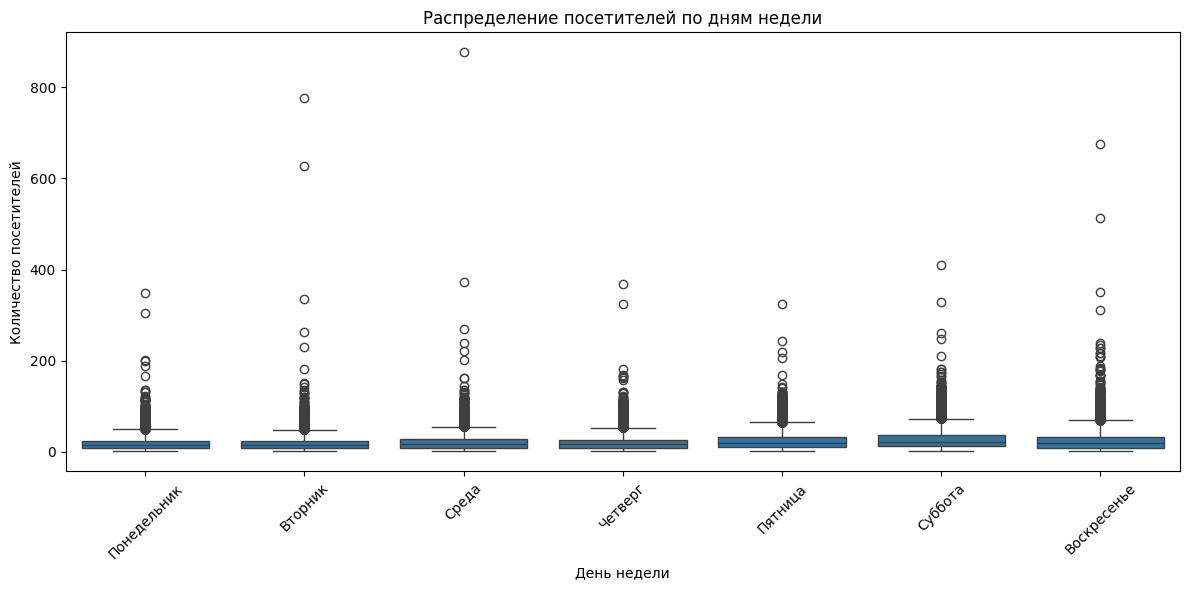

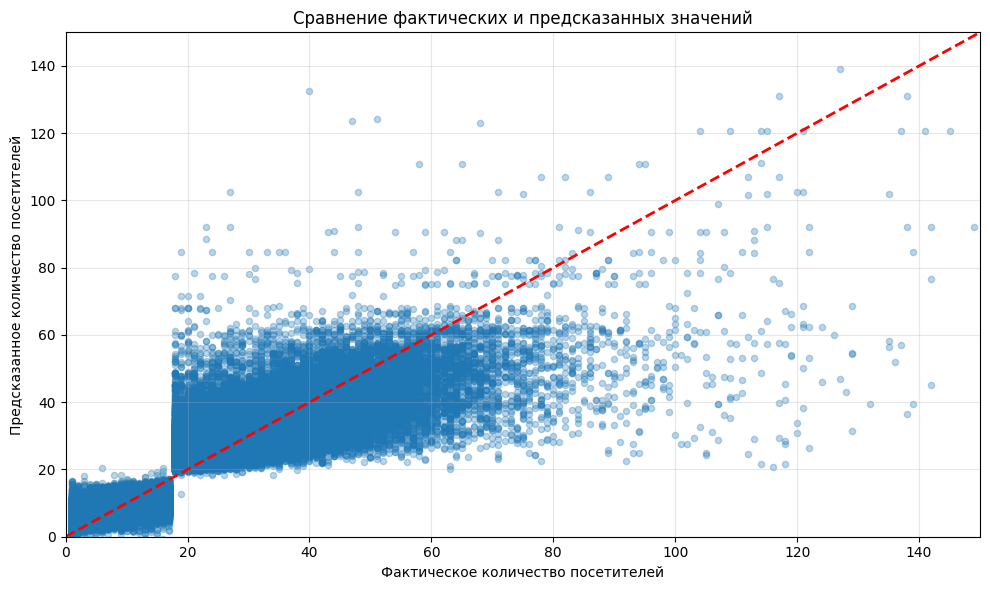

In [31]:
# График посетителей по дням недели
plt.figure(figsize=(12, 6))
days = ['Понедельник', 'Вторник', 'Среда', 'Четверг',
        'Пятница', 'Суббота', 'Воскресенье']
sns.boxplot(data=final_df, x='dayofweek', y='visitors', order=range(7))
plt.xticks(range(7), days, rotation=45)
plt.title('Распределение посетителей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество посетителей')
plt.tight_layout()
plt.show()

# Оптимизированный график предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, s=20)
plt.plot([0, 150], [0, 150], 'r--', lw=2)
plt.xlim(0, 150)
plt.ylim(0, 150)
plt.xlabel('Фактическое количество посетителей')
plt.ylabel('Предсказанное количество посетителей')
plt.title('Сравнение фактических и предсказанных значений')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

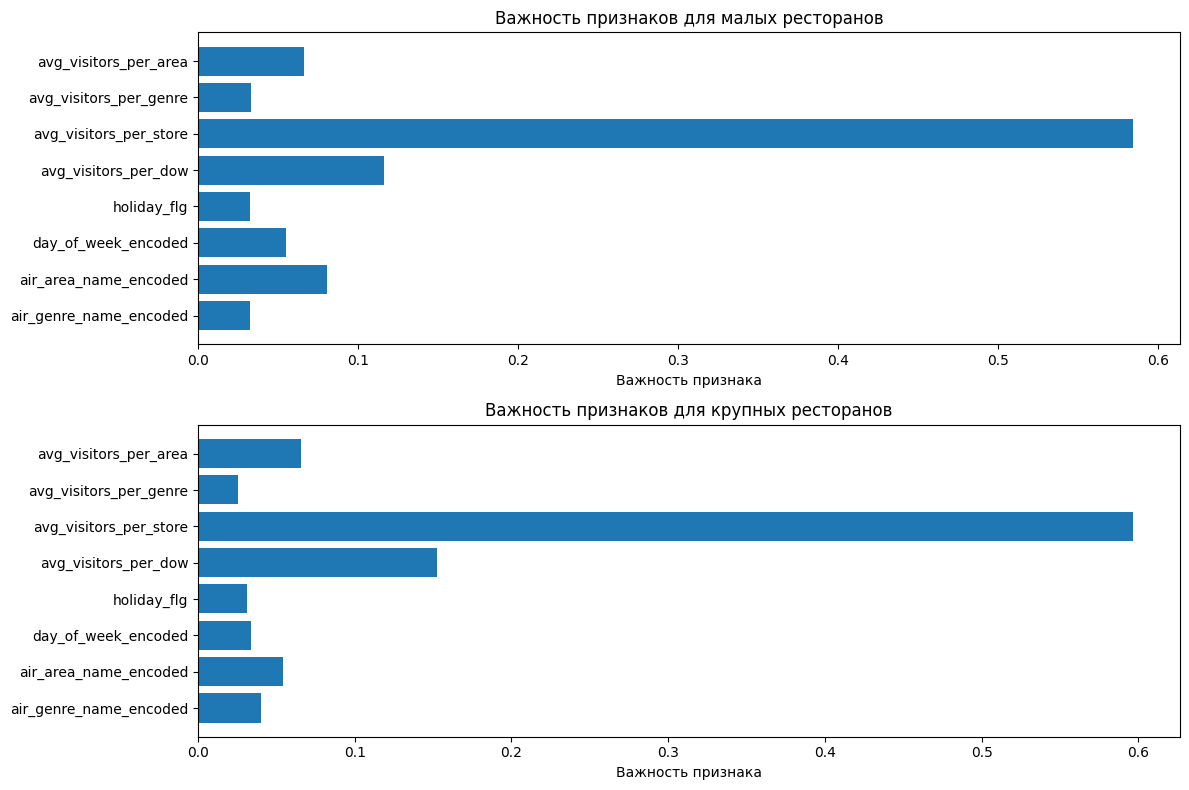

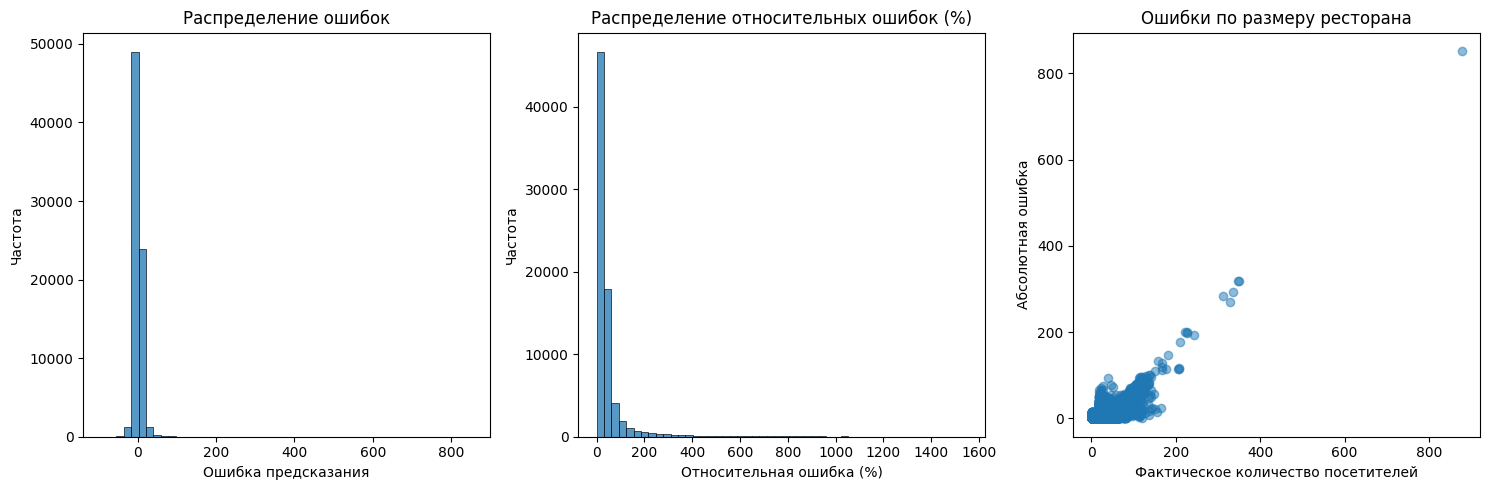

Средняя абсолютная ошибка: 5.50
Медианная абсолютная ошибка: 3.77
Средняя относительная ошибка: 46.50%
Медианная относительная ошибка: 23.69%


In [32]:
# График важности признаков для обеих моделей
plt.figure(figsize=(12, 8))

# Важность признаков для малых ресторанов
importances_small = pd.DataFrame({
    'feature': features,
    'importance': model_small.feature_importances_,
    'model': ['Малые рестораны'] * len(features)
})

# Важность признаков для крупных ресторанов
importances_large = pd.DataFrame({
    'feature': features,
    'importance': model_large.feature_importances_,
    'model': ['Крупные рестораны'] * len(features)
})

importances = pd.concat([importances_small, importances_large])
importances = importances.sort_values(['model', 'importance'], ascending=[True, True])

plt.subplot(211)
plt.barh(range(len(features)), importances_small['importance'])
plt.yticks(range(len(features)), importances_small['feature'])
plt.xlabel('Важность признака')
plt.title('Важность признаков для малых ресторанов')

plt.subplot(212)
plt.barh(range(len(features)), importances_large['importance'])
plt.yticks(range(len(features)), importances_large['feature'])
plt.xlabel('Важность признака')
plt.title('Важность признаков для крупных ресторанов')

plt.tight_layout()
plt.show()

# Анализ ошибок предсказания
y_test_combined = np.concatenate([y_test_small, y_test_large])
y_pred_combined = np.concatenate([y_pred_small, y_pred_large])

errors = y_test_combined - y_pred_combined
relative_errors = np.abs(errors / y_test_combined) * 100

plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(errors, bins=50)
plt.title('Распределение ошибок')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')

plt.subplot(132)
sns.histplot(relative_errors, bins=50)
plt.title('Распределение относительных ошибок (%)')
plt.xlabel('Относительная ошибка (%)')
plt.ylabel('Частота')

plt.subplot(133)
plt.scatter(y_test_combined, np.abs(errors), alpha=0.5)
plt.xlabel('Фактическое количество посетителей')
plt.ylabel('Абсолютная ошибка')
plt.title('Ошибки по размеру ресторана')

plt.tight_layout()
plt.show()

print(f'Средняя абсолютная ошибка: {np.mean(np.abs(errors)):.2f}')
print(f'Медианная абсолютная ошибка: {np.median(np.abs(errors)):.2f}')
print(f'Средняя относительная ошибка: {np.mean(relative_errors):.2f}%')
print(f'Медианная относительная ошибка: {np.median(relative_errors):.2f}%')